In [40]:
# Technical test  Detection and classification of “salad & fruit bar” 

In [ ]:
#All necessary import
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
import keras
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
from keras_frcnn.simple_parser import get_data
import keras_frcnn.resnet as nn
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib import patches

In [38]:
def detect_and_classify_vrac(img_path):
    # number of Regions of Interest per step
    num_rois = 32

    with open("config.pickle", 'rb') as f_in:
        C = pickle.load(f_in)

    # turn off any data augmentation at test time
    C.use_horizontal_flips = False
    C.use_vertical_flips = False
    C.rot_90 = False

    def format_img_size(img, C):
        """ formats the image size based on config """
        img_min_side = float(C.im_size)
        (height,width,_) = img.shape

        if width <= height:
            ratio = img_min_side/width
            new_height = int(ratio * height)
            new_width = int(img_min_side)
        else:
            ratio = img_min_side/height
            new_width = int(ratio * width)
            new_height = int(img_min_side)
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        return img, ratio	

    def format_img_channels(img, C):
        """ formats the image channels based on config """
        img = img[:, :, (2, 1, 0)]
        img = img.astype(np.float32)
        img[:, :, 0] -= C.img_channel_mean[0]
        img[:, :, 1] -= C.img_channel_mean[1]
        img[:, :, 2] -= C.img_channel_mean[2]
        img /= C.img_scaling_factor
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img, axis=0)
        return img

    def format_img(img, C):
        """ formats an image for model prediction based on config """
        img, ratio = format_img_size(img, C)
        img = format_img_channels(img, C)
        return img, ratio

    # Method to transform the coordinates of the bounding box to its original size
    def get_real_coordinates(ratio, x1, y1, x2, y2):

        real_x1 = int(round(x1 // ratio))
        real_y1 = int(round(y1 // ratio))
        real_x2 = int(round(x2 // ratio))
        real_y2 = int(round(y2 // ratio))

        return (real_x1, real_y1, real_x2 ,real_y2)

    class_mapping = C.class_mapping

    if 'bg' not in class_mapping:
        class_mapping['bg'] = len(class_mapping)

    class_mapping = {v: k for k, v in class_mapping.items()}

    class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
    C.num_rois = int(num_rois)

    #resnet:
    num_features = 1024

    if K.common.image_dim_ordering() == 'th':
        input_shape_img = (3, None, None)
        input_shape_features = (num_features, None, None)
    else:
        input_shape_img = (None, None, 3)
        input_shape_features = (None, None, num_features)


    img_input = Input(shape=input_shape_img)
    roi_input = Input(shape=(C.num_rois, 4))
    feature_map_input = Input(shape=input_shape_features)

    # define the base network (resnet here, can be VGG, Inception, etc)
    shared_layers = nn.nn_base(img_input, trainable=True)

    # define the RPN, built on the base layers
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
    rpn_layers = nn.rpn(shared_layers, num_anchors)

    classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

    model_rpn = Model(img_input, rpn_layers)
    model_classifier_only = Model([feature_map_input, roi_input], classifier)

    model_classifier = Model([feature_map_input, roi_input], classifier)

    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)

    model_rpn.compile(optimizer='sgd', loss='mse')
    model_classifier.compile(optimizer='sgd', loss='mse')

    results = []

    bbox_threshold = 0.8

    visualise = True

    if not img_path.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        print('verify the file type, accepted : bmp, jpeg, jpg, png, tif, tiff')
        return
        
    st = time.time()
    #filepath = os.path(img_path)

    img = cv2.imread(img_path)

    X, ratio = format_img(img, C)

    if K.common.image_dim_ordering() == 'tf':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.common.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
            results += [{"image": img_path.split('\\')[-1], "x1": real_x1, "y1": real_y1, "x2": real_x2, "y2": real_y2, "class_name" : key, "proba" :int(100*new_probs[jk]) }]



    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    #cv2.imshow('img', img)
    #cv2.waitKey(0)
    #cv2.imwrite('./results_imgs/{}.png'.format(idx),img)

    df_results = pd.DataFrame(results)
    
    # plot the detected objects
    # predicted image
    fig = plt.figure()

    ## Add axes to the image
    ax = fig.add_axes([0,0,1,1])

    image = plt.imread(img_path)
    plt.imshow(image)

    # Iterating over the image for different objects
    for _,row in df_results.iterrows():
        xmin = row.x1
        xmax = row.x2
        ymin = row.y1
        ymax = row.y2

        width = xmax - xmin
        height = ymax - ymin

        # assign different color to different classes of objects
        if row.class_name == 'big_vrac':
            edgecolor = 'r'
            ax.annotate('big_vrac', xy=(xmax-100,ymin+20),c='r')
        elif row.class_name == 'small_vrac':
            edgecolor = 'b'
            ax.annotate('small_vrac', xy=(xmax-100,ymin+20),c='b')

        # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')

        ax.add_patch(rect)

    plt.title("Predicted classes")
    return df_results

Given this function, one can detect and classify images:

Loading weights from ./model_frcnn.hdf5
Elapsed time = 9.352249145507812
[('big_vrac', 91.80406928062439), ('big_vrac', 86.36455535888672), ('big_vrac', 81.21162056922913), ('big_vrac', 80.74100613594055)]


,image,x1,y1,x2,y2,class_name,proba
0,im_0.jpg,256,51,563,448,big_vrac,91
1,im_0.jpg,243,89,435,320,big_vrac,86
2,im_0.jpg,64,204,217,371,big_vrac,81
3,im_0.jpg,371,166,563,435,big_vrac,80


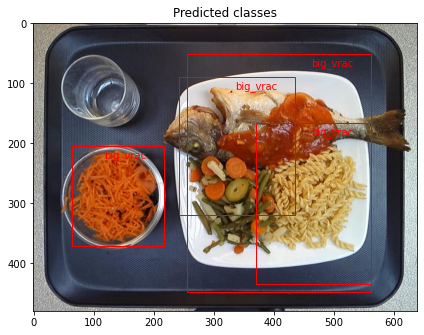

In [39]:
#Variable definitions
current_working_directory = os.getcwd()


detect_and_classify_vrac(current_working_directory+"\im_0.jpg")